# ESDA with pyGeoDa

`pygeoda` is a collection of python bindings of libgeoda, which is a C++ library that provides core functions of spatial data analysis in GeoDa. Unlike the desktop software GeoDa, `pygeoda` is a non-UI and function focused python library that is designed for Python programmers to do spatial data analysis in Python.  

In previous notebook, we did a quick tour of using `pygeoda` to:
1. load a spatial dataset and create a pygeoda instance
2. access attribute data and column data
3. create a Queen contiguity weights
4. compute local indicators of spatial autocorrelation (LISA) using the Queen contiguity weights
5. apply a spatially constrained clustering algorithm (SKATER) to find clusters

For exploratory spatial data analysis (ESDA), `pygeoa` provides some utility functions to allow users to easily work with geopandas and matplotlib to visualize the results and do exploratory spatial data analysis.

In this notebook, you will learn how to do ESDA with `pygeoda`, `geopandas` and `matplotlib`/`geoplot`.

## 1. Install GeoPandas and Matplotlib

### 1.1 GeoPandas
geopandas is a python library that allow users to work with geospatial data in Python. It is an extension of `pandas` python library by supporting `GeoSeries` type to allow spatial operations on geometric types besides traditional data manipulation and analysis.

geopandas  can be installed using conda or pip:
```
pip install geopandas
```

> Note: there are many dependencies of geopandas, so please check it's [documentation](http://geopandas.org/install.html) if encounting any issues.
* numpy
* pandas (version 0.19.1 or later)
* shapely (interface to GEOS)
* fiona (interface to GDAL)
* pyproj (interface to PROJ)
* six

Depending on the installation of GDAL library on your machine, the geospatial formats supported by geopandas varies. However, geopandas can be created using a GDAL datasource:
```Python
import ogr, geopandas
ds = ogr.Open('data_path')
lyr = ds[0]
gdf = geopandas.GeoDataFrame(lyr)
```
Using this approach, geopandas could load any geospatial data that is supported by GDAL literally. 

### 1.2 Matplotlib
Matplotlib is a Python 2D plotting library for making plots and maps. geopandas provides functions to directly call interfaces of Matplotlib to visualize maps, e.g. `geodataframe.plot(column='')`.

matplotlib can be installed using conda or pip:
```shell
pip install matplotlib
```

## 2. Start from GeoPandas

geopandas has been an essential python library to handle geospatial data, apply spatial operations and visualize maps. It is becoming an entry point of the spatial data analysis. A typical workflow of spatial data analysis in python could be beginning with geopandas: either load a geospatial data (e.g. ESRI shapefile) using geopandas, or create a geopandas dataframe from raw data like spreadsheets, databases etc. The geodataframe is then used to do spatial data analysis, store the results of data analysis, and finally visualize the results in terms of plots and maps using matplotlib. 

In this notebook, the geospatial dataset `Guerry` in ESRI Shapefile format will be used for demonstration. You can download this dataset at: http://GeoDaCenter.github.io/data-and-lab/

### 2.1 Load geospatial data in GeoPandas
To load this geospatial data in GeoPandas:

In [2]:
import geopandas

gdf = geopandas.read_file("/Users/xun/github/libgeoda/data/Guerry.shp")

That's it! You will get an instance of `geodataframe`: gdf. You can check the meta data and content of this geodataframe:

In [3]:
gdf.head
# Get geometries
gdf.geometry[:10]
# Get column names
gdf.columns
# Get projection info in crs format:
gdf.crs

{'init': 'epsg:27572'}

You can simply call function `plot()` to render the geospatial data as a map on a plot (matplotlib):

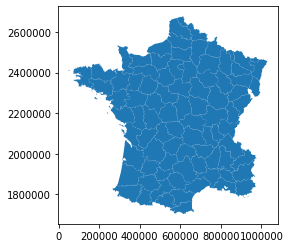

In [19]:
gdf.plot()

### 2.2 Make choropleth map using geopandas

Population per Crime against persons

In [5]:
import matplotlib
import matplotlib.pyplot as plt


### 2.2 Create pygeoda object from geodataframe

pygeoda provides a utility function `geopandas_to_geoda` to easily create a pygeoda instance for spatial data analysis:

In [6]:
from pygeoda import GeoDa, geopandas_to_geoda

guerry_geoda = geopandas_to_geoda(gdf)

geopandas_to_geoda


> Note: the conversion is based on using Well-Known-Binary (WKB) format to exchange geometric data for good performance.

The function `geopandas_to_geoda()` returns an object of `GeoDa` class, which can be then used to access GeoDa functions to do spatial data analysis. For example, to examine the local Moran of variable “crm_prs” (Population per Crime against persons), we first create a Queen contiguity weights:



In [7]:
queen_w = guerry_geoda.CreateContiguityWeights()

The function `CreateContiguityWeights()` returns an object of `GeoDaWeight` class. You can access the meta data of the weights as described in previous notebook. 

Here, we can use this weights object to compute the local Moran of variable "crm_prs" by calling function `LISA()`:

In [8]:
crm_lisa = guerry_geoda.LISA(queen_w, gdf.Crm_prs.to_list())

>Note: the first parameter of LISA() function is a weights object, and the second parameter is a list of numeric values (of selected variable "Crm_prs"). One can use `gdf.Crm_prs.to_list()` or use `guerry_geoda.GetNumericCol('Crm_prs')` to create the list.

Now, with the LISA results `crm_lisa`, we can do exploratory spatial data analysis by generating a LISA cluster map:



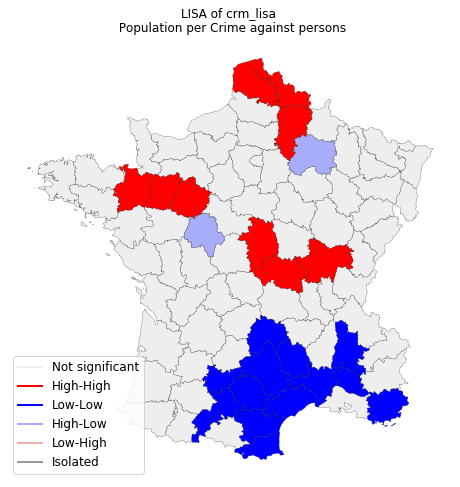

In [18]:
# attach LISA cluster indicators to geodataframe
gdf['LISA'] = crm_lisa.GetClusterIndicators()

from pygeoda import lisa_colors, lisa_labels, lisa_legend

fig, ax = plt.subplots(figsize = (8,10))

for ctype, data in gdf.groupby('LISA'):
    color = lisa_colors[ctype]
    lbl = lisa_labels[ctype]
    data.plot(color = color, 
              ax = ax, 
              label = lbl, 
              edgecolor = 'black', 
              linewidth = 0.2)

# Place legend in the lower right hand corner of the plot
ax.legend(lisa_legend, lisa_labels.values(),loc='lower left', fontsize=12, frameon=True)
ax.set(title='LISA of crm_lisa \n Population per Crime against persons')
ax.set_axis_off()

The code block above first store the LISA cluster indicators to geodataframe, then call it's `plot()` function to draw the LISA map. To help users to create identical LISA map as in GeoDa software, pygeoda provides some constant variables e.g. `lisa_colors`, `lisa_labels`, and `lisa_legend` for easily making a map. User can also specify their own color scheme, labels or legend. Please refer to the following code provided by pygeoda:

```python
lisa_colors = {0:'#eeeeee', 1 : '#FF0000', 2 : '#0000FF', 3:'#a7adf9', 4 :'#f4ada8', 5 :'#999999'}
lisa_labels = {0:'Not significant', 1:'High-High', 2:'Low-Low', 3:'High-Low', 4:'Low-High', 5:'Isolated'}
```

Using the significance values from `crm_lisa`, we can create a significance map that is associated with the LISA map above:

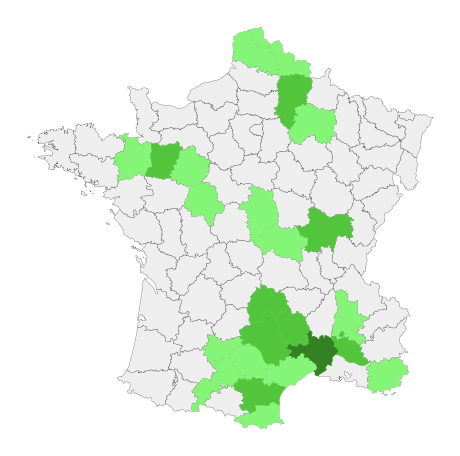

In [43]:
gdf['LISA_PVAL'] = crm_lisa.GetLocalSignificanceValues()

fig, ax = plt.subplots(figsize = (8,10))

gdf.plot(column='LISA_PVAL', color='#eeeeee', ax=ax, edgecolor = 'black', linewidth = 0.2)
gdf[gdf['LISA_PVAL'] <= 0.05].plot(color="#84f576", ax=ax)
gdf[gdf['LISA_PVAL'] <= 0.01].plot(color="#53c53c", ax=ax)
gdf[gdf['LISA_PVAL'] <= 0.001].plot(color="#348124", ax=ax)

ax.set_axis_off()